# Data preparation

In [1]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class ColonoscopyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
    
        self.root_dir = root_dir
        self.transform = transform
        self.image_dir = os.path.join(root_dir, 'images')
        self.label_dir = os.path.join(root_dir, 'labels')
        self.image_files = [f for f in os.listdir(self.image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        
    
        label_name = os.path.join(self.label_dir, os.path.splitext(self.image_files[idx])[0] + '.txt')
        
        boxes = []
        labels = []
        
        if os.path.exists(label_name):
            with open(label_name, 'r') as f:
                for line in f.readlines():
                    data = line.strip().split()
                    if len(data) == 5:  
                        class_id = int(data[0])
                        x_center = float(data[1])
                        y_center = float(data[2])
                        width = float(data[3])
                        height = float(data[4])
                        
                        
                        x_min = x_center - width/2
                        y_min = y_center - height/2
                        x_max = x_center + width/2
                        y_max = y_center + height/2
                        
                        boxes.append([x_min, y_min, x_max, y_max])
                        labels.append(class_id)
        
      
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

# Visualization of data

In [46]:
def plot_image_with_boxes(image, target, class_names=None):

    if isinstance(image, torch.Tensor):
   
        image = transforms.ToPILImage()(image)
    
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    if 'boxes' in target:
        boxes = target['boxes']
        labels = target['labels']
        
        for i, box in enumerate(boxes):
           
            width, height = image.size
            x_min, y_min, x_max, y_max = box
            x_min *= width
            x_max *= width
            y_min *= height
            y_max *= height
            
            rect = patches.Rectangle(
                (x_min, y_min), 
                x_max - x_min, 
                y_max - y_min,
                linewidth=2,
                edgecolor='r',
                facecolor='none'
            )
            ax.add_patch(rect)
            
            if class_names and i < len(labels):
                label = class_names[labels[i]]
                plt.text(x_min, y_min - 5, label, color='red', fontsize=12)
    
    plt.axis('off')
    plt.show()

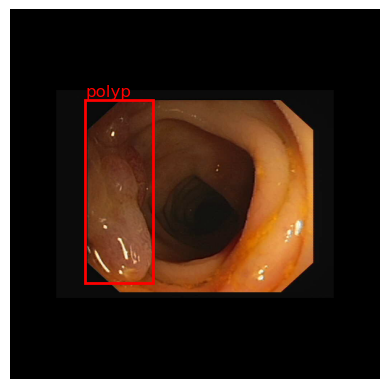

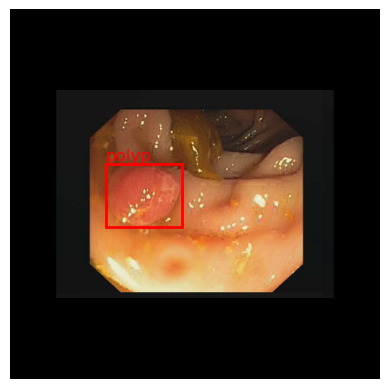

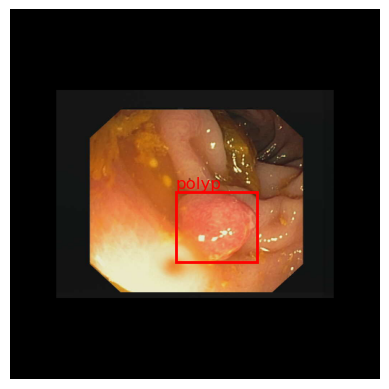

In [48]:
train_path = r"C:\Users\User\OneDrive\Рабочий стол\Diploma project\data_for_modeling\train"
val_path = r"C:\Users\User\OneDrive\Рабочий стол\Diploma project\data_for_modeling\val"
test_path = r"C:\Users\User\OneDrive\Рабочий стол\Diploma project\data_for_modeling\test"

class_names = ['polyp', 'other_lesion']  

train_dataset = ColonoscopyDataset(train_path)
val_dataset = ColonoscopyDataset(val_path)
test_dataset = ColonoscopyDataset(test_path)


num_samples = 3
for i in range(min(num_samples, len(train_dataset))):
    image, target = train_dataset[i]
    plot_image_with_boxes(image, target, class_names)

# Data augmentation

In [52]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Resize((512, 512))
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 512))
])

train_dataset = ColonoscopyDataset(train_path, transform=train_transform)
val_dataset = ColonoscopyDataset(val_path, transform=val_transform)
test_dataset = ColonoscopyDataset(test_path, transform=val_transform)

In [54]:
def collate_fn(batch):
    return tuple(zip(*batch))

batch_size = 4
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=collate_fn
)

# YOLO v8n

In [ ]:
from ultralytics import YOLO


model = YOLO('yolo8n.pt')  


results = model.train(
    data='colonoscopy.yaml',
    epochs=100,
    batch=8,
    imgsz=640,
    device='0', 
    workers=4,
    lr0=0.01,  
    patience=50,  
    name='yolov8n_colonoscopy'
)

New https://pypi.org/project/ultralytics/8.3.142 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.101  Python-3.12.4 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolo11n.pt, data=colonoscopy.yaml, epochs=100, time=None, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=4, project=None, name=yolov11m_colonoscopy2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None

train: Scanning C:\Users\User\OneDrive\Рабочий стол\Diploma project\data_for_modeling\train\labels.cache... 2822 images, 105 backgrounds, 0 corrupt: 100%|██████████| 2822/2822 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


C:\Users\User\anaconda3\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning C:\Users\User\OneDrive\Рабочий стол\Diploma project\data_for_modeling\val\labels.cache... 352 images, 8 backgrounds, 0 corrupt: 100%|██████████| 352/352 [00:00<?, ?it/s]


In [27]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt') 

results = model.train(
    data='colonoscopy.yaml',
    epochs=100,
    batch=8,
    imgsz=640,
    device='0', 
    workers=4,
    lr0=0.01, 
    patience=50,  
    name='yolov8n_colonoscopy'
)

Ultralytics 8.3.101  Python-3.12.4 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=colonoscopy.yaml, epochs=100, time=None, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=4, project=None, name=yolov8n_colonoscopy, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sh

100%|██████████| 755k/755k [00:00<00:00, 1.99MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 9.24MB/s]


AMP: checks passed 


train: Scanning C:\Users\User\OneDrive\Рабочий стол\Diploma project\data_for_modeling\train\labels... 2822 images, 105 backgrounds, 0 corrupt: 100%|██████████| 2822/2822 [00:04<00:00, 614.60it/s]


train: New cache created: C:\Users\User\OneDrive\ \Diploma project\data_for_modeling\train\labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning C:\Users\User\OneDrive\Рабочий стол\Diploma project\data_for_modeling\val\labels... 352 images, 8 backgrounds, 0 corrupt: 100%|██████████| 352/352 [00:00<00:00, 421.96it/s]

val: New cache created: C:\Users\User\OneDrive\ \Diploma project\data_for_modeling\val\labels.cache


Plotting labels to C:\Users\User\runs\detect\yolov8n_colonoscopy\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to C:\Users\User\runs\detect\yolov8n_colonoscopy
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.13G      1.156      2.399      1.413          8        640: 100%|██████████| 353/353 [01:07<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  5.29it/s]

                   all        352        375      0.621      0.557      0.599      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.29G       1.27      1.814      1.483         10        640: 100%|██████████| 353/353 [01:00<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.14it/s]

                   all        352        375      0.508      0.484      0.506      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.29G      1.286      1.653      1.487          8        640: 100%|██████████| 353/353 [01:01<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.98it/s]

                   all        352        375      0.665      0.656      0.694      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.29G      1.233      1.501      1.451         14        640: 100%|██████████| 353/353 [01:01<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.60it/s]

                   all        352        375      0.732      0.598      0.682      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.29G      1.227      1.449      1.444          6        640: 100%|██████████| 353/353 [01:00<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.96it/s]

                   all        352        375      0.801      0.717      0.795      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.29G      1.194      1.364      1.412         10        640: 100%|██████████| 353/353 [01:00<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.13it/s]

                   all        352        375      0.764      0.716      0.783       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.29G      1.173      1.315      1.408         10        640: 100%|██████████| 353/353 [01:00<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.86it/s]

                   all        352        375      0.804      0.696      0.784       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.29G      1.147      1.258      1.367         10        640: 100%|██████████| 353/353 [01:01<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.54it/s]

                   all        352        375      0.825      0.749      0.826      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.29G      1.144      1.262      1.364         10        640: 100%|██████████| 353/353 [01:01<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.54it/s]

                   all        352        375      0.754      0.731        0.8      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.29G      1.111      1.207      1.358         16        640: 100%|██████████| 353/353 [00:59<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.29it/s]

                   all        352        375      0.804      0.743      0.814      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.29G      1.103      1.194      1.352         12        640: 100%|██████████| 353/353 [00:59<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.68it/s]

                   all        352        375       0.82       0.76      0.831      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.29G      1.118      1.169      1.366         12        640: 100%|██████████| 353/353 [01:00<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.08it/s]

                   all        352        375      0.835       0.72      0.818      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.29G      1.091      1.177      1.349          9        640: 100%|██████████| 353/353 [00:59<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.66it/s]

                   all        352        375      0.852      0.683        0.8      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.29G      1.081      1.124      1.331         10        640: 100%|██████████| 353/353 [01:00<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.75it/s]

                   all        352        375      0.828      0.772      0.842      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.29G       1.06      1.108      1.321          9        640: 100%|██████████| 353/353 [01:00<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.92it/s]

                   all        352        375      0.889      0.707      0.841      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.29G      1.083      1.118      1.324         10        640: 100%|██████████| 353/353 [01:00<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.58it/s]

                   all        352        375      0.859       0.75      0.847      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.29G      1.053      1.065      1.301         11        640: 100%|██████████| 353/353 [01:00<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.88it/s]

                   all        352        375       0.89      0.775      0.863      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.29G      1.023      1.042      1.285          9        640: 100%|██████████| 353/353 [00:59<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.23it/s]

                   all        352        375      0.814      0.784      0.847      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.29G      1.013       1.02      1.283          6        640: 100%|██████████| 353/353 [01:01<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.09it/s]

                   all        352        375      0.872      0.739      0.871      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.29G      1.016      1.038       1.28         12        640: 100%|██████████| 353/353 [01:00<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.16it/s]

                   all        352        375      0.874      0.794      0.876       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.29G      1.017      1.025      1.277         10        640: 100%|██████████| 353/353 [00:59<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.87it/s]

                   all        352        375      0.878      0.773      0.863      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.29G      1.015      1.007      1.283          9        640: 100%|██████████| 353/353 [01:00<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.04it/s]

                   all        352        375      0.873      0.792      0.872      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.29G     0.9887     0.9797      1.272         10        640: 100%|██████████| 353/353 [01:00<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.88it/s]

                   all        352        375      0.879       0.74      0.868      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.29G     0.9921     0.9676      1.263         11        640: 100%|██████████| 353/353 [00:59<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.35it/s]

                   all        352        375      0.827      0.779      0.856      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.29G     0.9698     0.9561       1.25          9        640: 100%|██████████| 353/353 [01:00<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.82it/s]

                   all        352        375      0.883       0.76      0.874      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.29G     0.9827     0.9648      1.259         16        640: 100%|██████████| 353/353 [01:01<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.16it/s]

                   all        352        375      0.917      0.741      0.875      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.29G     0.9665     0.9455      1.252         10        640: 100%|██████████| 353/353 [00:58<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.37it/s]

                   all        352        375      0.881      0.803      0.883      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.29G      0.943     0.9279      1.241          8        640: 100%|██████████| 353/353 [00:58<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.35it/s]

                   all        352        375      0.915      0.752       0.88       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.29G     0.9526     0.9175      1.251          8        640: 100%|██████████| 353/353 [00:58<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.46it/s]

                   all        352        375      0.897      0.781      0.884      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.29G     0.9526     0.9297      1.245         15        640: 100%|██████████| 353/353 [00:58<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.22it/s]

                   all        352        375      0.841      0.795      0.858      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.29G     0.9305     0.9007      1.233          8        640: 100%|██████████| 353/353 [00:58<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.26it/s]

                   all        352        375      0.892      0.776      0.879      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.29G       0.93     0.8765      1.221         17        640: 100%|██████████| 353/353 [00:59<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.76it/s]

                   all        352        375      0.884      0.816      0.894      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.29G     0.9258     0.8787      1.229         12        640: 100%|██████████| 353/353 [01:00<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  5.45it/s]

                   all        352        375      0.888      0.803      0.882      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.29G     0.9401     0.8654      1.226         12        640: 100%|██████████| 353/353 [01:00<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  5.23it/s]

                   all        352        375      0.855      0.813      0.881      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.29G     0.9434     0.8923      1.225         15        640: 100%|██████████| 353/353 [01:01<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.07it/s]

                   all        352        375      0.878       0.81      0.889       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.29G     0.9353     0.8799      1.239         13        640: 100%|██████████| 353/353 [00:59<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.70it/s]

                   all        352        375      0.912      0.797       0.89      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.29G     0.9136     0.8577      1.204          6        640: 100%|██████████| 353/353 [00:59<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.87it/s]

                   all        352        375      0.862      0.819      0.898      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.29G     0.9196     0.8458      1.223         11        640: 100%|██████████| 353/353 [00:59<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.09it/s]

                   all        352        375      0.911      0.779      0.887      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.29G       0.91     0.8377      1.211         12        640: 100%|██████████| 353/353 [00:58<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.20it/s]

                   all        352        375      0.901      0.804      0.896      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.29G     0.8873     0.8327      1.191         13        640: 100%|██████████| 353/353 [01:00<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.93it/s]

                   all        352        375      0.889      0.829      0.896      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.29G     0.8886     0.8375      1.187          9        640: 100%|██████████| 353/353 [01:00<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.90it/s]

                   all        352        375       0.91      0.813      0.901      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.29G      0.876     0.8128        1.2         12        640: 100%|██████████| 353/353 [01:00<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.92it/s]

                   all        352        375      0.883      0.862      0.912      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.29G     0.8735     0.7911      1.188          4        640: 100%|██████████| 353/353 [01:02<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  4.74it/s]

                   all        352        375      0.888      0.806       0.89      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.29G     0.8801     0.8158      1.192         14        640: 100%|██████████| 353/353 [01:02<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  5.36it/s]

                   all        352        375      0.912      0.781      0.892      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.29G     0.8865      0.812        1.2          8        640: 100%|██████████| 353/353 [01:02<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.00it/s]

                   all        352        375      0.871      0.829        0.9        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      1.29G     0.8799     0.8118       1.19         15        640: 100%|██████████| 353/353 [01:00<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.99it/s]

                   all        352        375      0.881      0.848       0.91      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.29G     0.8655     0.8021      1.181         12        640: 100%|██████████| 353/353 [01:00<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.90it/s]

                   all        352        375      0.917        0.8      0.894      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      1.29G     0.8617     0.7653      1.176          8        640: 100%|██████████| 353/353 [01:01<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.13it/s]

                   all        352        375      0.926      0.795      0.903      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      1.29G     0.8799     0.7889      1.192          8        640: 100%|██████████| 353/353 [00:59<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.76it/s]

                   all        352        375      0.924      0.811      0.908      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      1.29G     0.8485     0.7691       1.17         10        640: 100%|██████████| 353/353 [01:00<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.81it/s]

                   all        352        375      0.914      0.827      0.901      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      1.29G     0.8713     0.7697      1.174         11        640: 100%|██████████| 353/353 [01:03<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.55it/s]

                   all        352        375      0.867      0.851      0.915      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      1.29G     0.8522     0.7477      1.166         16        640: 100%|██████████| 353/353 [01:00<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.77it/s]

                   all        352        375      0.919      0.811      0.915      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      1.29G     0.8451     0.7438      1.168          9        640: 100%|██████████| 353/353 [01:00<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.82it/s]

                   all        352        375        0.9       0.84      0.911      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.29G     0.8343     0.7487      1.164          9        640: 100%|██████████| 353/353 [01:00<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.78it/s]

                   all        352        375      0.887      0.851      0.904      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      1.29G     0.8488     0.7529      1.178          8        640: 100%|██████████| 353/353 [01:00<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.99it/s]

                   all        352        375      0.893      0.844      0.906      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.29G     0.8266     0.7162      1.156         10        640: 100%|██████████| 353/353 [00:59<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.33it/s]

                   all        352        375      0.891      0.835        0.9      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      1.29G     0.8304     0.7178      1.161          7        640: 100%|██████████| 353/353 [00:59<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.58it/s]

                   all        352        375       0.91      0.814      0.907      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      1.29G     0.8243     0.7252      1.155         12        640: 100%|██████████| 353/353 [01:01<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.80it/s]

                   all        352        375      0.922        0.8      0.908      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      1.29G     0.8283     0.7097      1.157         14        640: 100%|██████████| 353/353 [01:01<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.11it/s]

                   all        352        375      0.894      0.821      0.905        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      1.29G     0.8095     0.7107      1.144         15        640: 100%|██████████| 353/353 [01:01<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.07it/s]

                   all        352        375      0.914      0.835      0.911       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      1.29G     0.8211     0.7156      1.164          5        640: 100%|██████████| 353/353 [00:59<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.04it/s]

                   all        352        375      0.915      0.827      0.901      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      1.29G     0.8277     0.7095      1.156          8        640: 100%|██████████| 353/353 [01:01<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.83it/s]

                   all        352        375      0.908      0.811       0.91       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.29G     0.8044     0.6887      1.145         16        640: 100%|██████████| 353/353 [00:59<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.19it/s]

                   all        352        375      0.892      0.835      0.909       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      1.29G      0.808     0.6937      1.141         18        640: 100%|██████████| 353/353 [01:01<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.06it/s]

                   all        352        375      0.908      0.803      0.894      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      1.29G     0.7975     0.6839      1.139         19        640: 100%|██████████| 353/353 [01:01<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.16it/s]

                   all        352        375      0.941      0.792      0.914      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      1.29G     0.7929     0.6653      1.134         14        640: 100%|██████████| 353/353 [01:00<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.72it/s]

                   all        352        375       0.92      0.824      0.904      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      1.29G     0.7954      0.661      1.135          9        640: 100%|██████████| 353/353 [01:00<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.30it/s]

                   all        352        375      0.902      0.834      0.912      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      1.29G     0.7983     0.6595      1.145         11        640: 100%|██████████| 353/353 [01:00<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.17it/s]

                   all        352        375      0.933       0.82      0.907      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.29G     0.7807     0.6515      1.128          8        640: 100%|██████████| 353/353 [01:00<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.19it/s]

                   all        352        375      0.917      0.835      0.912      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      1.29G     0.7808     0.6439      1.122         17        640: 100%|██████████| 353/353 [00:59<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.37it/s]

                   all        352        375      0.898      0.856      0.919      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.29G      0.785     0.6434      1.118         11        640: 100%|██████████| 353/353 [01:00<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.06it/s]

                   all        352        375      0.915      0.831      0.916      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      1.29G     0.7777     0.6533      1.127         14        640: 100%|██████████| 353/353 [00:59<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.88it/s]

                   all        352        375      0.905      0.851      0.913      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.29G     0.7578      0.634      1.115         17        640: 100%|██████████| 353/353 [01:00<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.62it/s]

                   all        352        375      0.934      0.831       0.92      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      1.29G     0.7747     0.6477      1.127          9        640: 100%|██████████| 353/353 [01:00<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.84it/s]

                   all        352        375      0.892      0.853      0.922       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      1.29G     0.7766      0.652      1.128          7        640: 100%|██████████| 353/353 [01:00<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.11it/s]


                   all        352        375      0.918      0.831      0.917      0.727

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      1.29G      0.755      0.614      1.108         11        640: 100%|██████████| 353/353 [00:59<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.16it/s]

                   all        352        375      0.895      0.832      0.912       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.29G     0.7603     0.6182      1.117         11        640: 100%|██████████| 353/353 [01:00<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.28it/s]

                   all        352        375      0.935       0.81       0.92      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      1.29G     0.7379     0.6107      1.102         16        640: 100%|██████████| 353/353 [01:54<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:30<00:00,  1.40s/it]

                   all        352        375      0.892      0.867      0.913      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      1.29G     0.7712     0.6204      1.114         12        640: 100%|██████████| 353/353 [01:01<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  5.39it/s]

                   all        352        375      0.929      0.834      0.917      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      1.29G     0.7516     0.6165      1.113          5        640: 100%|██████████| 353/353 [01:00<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.92it/s]

                   all        352        375      0.903      0.844      0.915      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      1.29G     0.7413     0.6056      1.098         10        640: 100%|██████████| 353/353 [01:12<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.98it/s]

                   all        352        375      0.907      0.843      0.913      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      1.29G     0.7504     0.6063      1.099         13        640: 100%|██████████| 353/353 [01:41<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:06<00:00,  3.62it/s]

                   all        352        375      0.912      0.851       0.92      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      1.29G     0.7395     0.5975      1.101         10        640: 100%|██████████| 353/353 [01:02<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.98it/s]

                   all        352        375        0.9      0.856      0.921      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      1.29G     0.7187     0.5763      1.085          8        640: 100%|██████████| 353/353 [01:01<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.87it/s]

                   all        352        375      0.901      0.845      0.916      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      1.29G     0.7332     0.5732      1.094         18        640: 100%|██████████| 353/353 [01:00<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.75it/s]

                   all        352        375      0.908      0.845      0.917      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      1.29G     0.7284     0.5799      1.086          8        640: 100%|██████████| 353/353 [01:01<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.86it/s]

                   all        352        375      0.922      0.819      0.912      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      1.29G     0.7235     0.5795      1.091          9        640: 100%|██████████| 353/353 [01:01<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.56it/s]

                   all        352        375      0.918      0.832      0.918      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      1.29G     0.7182     0.5681      1.088          7        640: 100%|██████████| 353/353 [01:00<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.96it/s]

                   all        352        375      0.922      0.846      0.918      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      1.29G     0.7105     0.5619      1.079          8        640: 100%|██████████| 353/353 [01:00<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.93it/s]

                   all        352        375      0.896      0.846      0.916      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      1.29G     0.7033     0.5524       1.08         10        640: 100%|██████████| 353/353 [00:59<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.95it/s]

                   all        352        375      0.922      0.837      0.915      0.734


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.29G     0.6109     0.4086     0.9967          5        640: 100%|██████████| 353/353 [00:59<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.02it/s]

                   all        352        375      0.916      0.841      0.915       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      1.29G     0.5991     0.4035     0.9932          4        640: 100%|██████████| 353/353 [00:59<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.74it/s]

                   all        352        375      0.931      0.833      0.915      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      1.29G     0.5929     0.3912     0.9859          6        640: 100%|██████████| 353/353 [00:59<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.09it/s]

                   all        352        375      0.916      0.829      0.918      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      1.29G     0.5927     0.3823     0.9867          6        640: 100%|██████████| 353/353 [00:59<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.98it/s]

                   all        352        375      0.931      0.819      0.915      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      1.29G     0.5807     0.3826     0.9761          6        640: 100%|██████████| 353/353 [00:59<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.43it/s]

                   all        352        375      0.915      0.832      0.912       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      1.29G     0.5809     0.3704      0.977          6        640: 100%|██████████| 353/353 [00:59<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.84it/s]

                   all        352        375      0.931      0.828      0.918       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      1.29G     0.5832     0.3645      0.973          6        640: 100%|██████████| 353/353 [00:59<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.19it/s]

                   all        352        375       0.94      0.824      0.916      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      1.29G     0.5687     0.3602     0.9663          6        640: 100%|██████████| 353/353 [00:59<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.37it/s]

                   all        352        375      0.937      0.832      0.917      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      1.29G     0.5684     0.3627     0.9673          6        640: 100%|██████████| 353/353 [00:59<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.03it/s]

                   all        352        375      0.918       0.84      0.916      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      1.29G     0.5655     0.3538     0.9664          5        640: 100%|██████████| 353/353 [00:59<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.06it/s]

                   all        352        375      0.932      0.827      0.914      0.741



100 epochs completed in 1.839 hours.
Optimizer stripped from C:\Users\User\runs\detect\yolov8n_colonoscopy\weights\last.pt, 6.3MB
Optimizer stripped from C:\Users\User\runs\detect\yolov8n_colonoscopy\weights\best.pt, 6.3MB

Validating C:\Users\User\runs\detect\yolov8n_colonoscopy\weights\best.pt...
Ultralytics 8.3.101  Python-3.12.4 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  5.91it/s]


                   all        352        375      0.916      0.829      0.918       0.74
                 polyp        344        375      0.916      0.829      0.918       0.74
Speed: 0.5ms preprocess, 4.8ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to C:\Users\User\runs\detect\yolov8n_colonoscopy


In [106]:
import pandas as pd
from pathlib import Path

results_dir = Path("C:/Users/User/runs/detect/yolov8n_colonoscopy")

def generate_metrics_table(results_dir):

    results_csv = results_dir / "results.csv"
    df = pd.read_csv(results_csv)
    

    last_epoch = df.iloc[-1]
    
    dice = 2 * (last_epoch['metrics/precision(B)'] * last_epoch['metrics/recall(B)']) / \
           (last_epoch['metrics/precision(B)'] + last_epoch['metrics/recall(B)'] + 1e-16)
    accuracy = last_epoch['metrics/precision(B)'] * last_epoch['metrics/recall(B)']
    total_loss = last_epoch['train/box_loss'] + last_epoch['train/cls_loss'] + last_epoch['train/dfl_loss']
    
    metrics_table = pd.DataFrame({
        "Experiment": ["YOLOv8n_colonoscopy", "YOLOv8n_colonoscopy", "YOLOv8n_colonoscopy"],
        "Stage": ["Train", "Validation", "Test"],
        "Loss": [total_loss, last_epoch['val/box_loss'] + last_epoch['val/cls_loss'] + last_epoch['val/dfl_loss'], "-"],
        "Dice": [dice, dice, "-"],
        "IoU": [last_epoch['metrics/mAP50(B)'], last_epoch['metrics/mAP50(B)'], "-"],
        "Accuracy": [accuracy, accuracy, "-"],
        "Box P": [last_epoch['metrics/precision(B)'], last_epoch['metrics/precision(B)'], "-"],
        "Box R": [last_epoch['metrics/recall(B)'], last_epoch['metrics/recall(B)'], "-"],
        "mAP50": [last_epoch['metrics/mAP50(B)'], last_epoch['metrics/mAP50(B)'], "-"],
        "mAP50-95": [last_epoch['metrics/mAP50-95(B)'], last_epoch['metrics/mAP50-95(B)'], "-"]
    })
    

    test_metrics = model.val(data='colonoscopy.yaml', split='test')
    if test_metrics:
        test_dice = 2 * (test_metrics.box.p * test_metrics.box.r) / (test_metrics.box.p + test_metrics.box.r + 1e-16)
        metrics_table.loc[2, 'Dice'] = test_dice
        metrics_table.loc[2, 'IoU'] = test_metrics.box.map50
        metrics_table.loc[2, 'Accuracy'] = test_metrics.box.p * test_metrics.box.r
        metrics_table.loc[2, 'Box P'] = test_metrics.box.p
        metrics_table.loc[2, 'Box R'] = test_metrics.box.r
        metrics_table.loc[2, 'mAP50'] = test_metrics.box.map50
        metrics_table.loc[2, 'mAP50-95'] = test_metrics.box.map
    
    return metrics_table

metrics_table = generate_metrics_table(results_dir)
print(metrics_table.to_markdown(index=False))

metrics_table.to_csv(results_dir / "summary_metrics.csv", index=False)
print(f"\nMetrics table saved to {results_dir/'summary_metrics.csv'}")

Ultralytics 8.3.101  Python-3.12.4 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)


val: Scanning C:\Users\User\OneDrive\Рабочий стол\Diploma project\data_for_modeling\test\labels.cache... 354 images, 13 backgrounds, 0 corrupt: 100%|██████████| 354/354 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.56it/s]


                   all        354        371      0.934      0.868       0.93      0.744
                 polyp        341        371      0.934      0.868       0.93      0.744
Speed: 0.7ms preprocess, 7.4ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to C:\Users\User\runs\detect\val5
| Experiment          | Stage      | Loss    |     Dice |      IoU |   Accuracy |    Box P |    Box R |    mAP50 |   mAP50-95 |
|:--------------------|:-----------|:--------|---------:|---------:|-----------:|---------:|---------:|---------:|-----------:|
| YOLOv8n_colonoscopy | Train      | 1.88574 | 0.876061 | 0.91437  |   0.770233 | 0.93173  | 0.82667  | 0.91437  |   0.74053  |
| YOLOv8n_colonoscopy | Validation | 2.51096 | 0.876061 | 0.91437  |   0.770233 | 0.93173  | 0.82667  | 0.91437  |   0.74053  |
| YOLOv8n_colonoscopy | Test       | -       | 0.899875 | 0.929711 |   0.810873 | 0.934267 | 0.867925 | 0.929711 |   0.743599 |

Metrics table saved to C:\Users\User\runs\detect\yo

# Evaluation 

In [86]:
from ultralytics import YOLO
import numpy as np


model = YOLO(r"C:\Users\User\runs\detect\yolov8n_colonoscopy\weights\best.pt")  


metrics = model.val(
    data='colonoscopy.yaml',
    split='test',
    batch=8,
    imgsz=640,
    conf=0.25,
    iou=0.45,
    device='0'
)


print("\nEvaluation Metrics:")
print(f"mAP50-95: {metrics.box.map:.4f}")       
print(f"mAP50: {metrics.box.map50:.4f}")         
print(f"mAP75: {metrics.box.map75:.4f}")      


if isinstance(metrics.box.p, np.ndarray):
    print(f"Precision: {metrics.box.p.mean():.4f}")  
    print(f"Recall: {metrics.box.r.mean():.4f}")   
    f1 = 2 * (metrics.box.p.mean() * metrics.box.r.mean()) / (metrics.box.p.mean() + metrics.box.r.mean() + 1e-16)
    print(f"F1 Score: {f1:.4f}")
else:
    print(f"Precision: {metrics.box.p:.4f}")
    print(f"Recall: {metrics.box.r:.4f}")
    print(f"F1 Score: {2*(metrics.box.p*metrics.box.r)/(metrics.box.p+metrics.box.r+1e-16):.4f}")

Ultralytics 8.3.101  Python-3.12.4 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\Users\User\OneDrive\Рабочий стол\Diploma project\data_for_modeling\test\labels.cache... 354 images, 13 backgrounds, 0 corrupt: 100%|██████████| 354/354 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:04<00:00, 10.39it/s]


                   all        354        371      0.942      0.873      0.932      0.777
                 polyp        341        371      0.942      0.873      0.932      0.777
Speed: 0.5ms preprocess, 7.7ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to C:\Users\User\runs\detect\val3

Evaluation Metrics:
mAP50-95: 0.7769
mAP50: 0.9318
mAP75: 0.8500
Precision: 0.9419
Recall: 0.8732
F1 Score: 0.9062


# Visualizations

In [88]:
def visualize_detections(image_path, model, conf_thresh=0.3):
    results = model.predict(image_path, conf=conf_thresh)
    
    for r in results:
     
        im_array = r.plot(line_width=2, font_size=0.8)
        
        im_rgb = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(12, 8))
        plt.imshow(im_rgb)
        plt.axis('off')
        plt.show()
        
        print(f"\nDetections (conf ≥ {conf_thresh}):")
        for i, box in enumerate(r.boxes):
            print(f"Object {i+1}: {model.names[int(box.cls)]}")
            print(f"  Confidence: {box.conf.item():.4f}")
            print(f"  BBox: {[round(x,2) for x in box.xyxy[0].tolist()]}")

In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import glob
import os
import random
import numpy as np
from PIL import Image


NUM_IMAGES_TO_SHOW = 10 
CONF_THRESHOLD = 0.25   
IMG_FORMATS = ['*.jpg', '*.jpeg', '*.png']


model = YOLO(r"C:\Users\User\runs\detect\yolov8n_colonoscopy\weights\best.pt")  
def find_test_images_and_labels():
    search_locations = [
        'data/test/images',
        'dataset/test/images', 
        'test/images',
        'images/test',
        'val/images',
        'data/valid/images',
        '.' 
    ]
    
    test_pairs = []
    for location in search_locations:
        image_dir = location
        label_dir = location.replace('images', 'labels')
        
        for fmt in IMG_FORMATS:
            for img_path in glob.glob(os.path.join(image_dir, fmt)):
                base_name = os.path.splitext(os.path.basename(img_path))[0]
                label_path = os.path.join(label_dir, f"{base_name}.txt")
                if os.path.exists(label_path):
                    test_pairs.append((img_path, label_path))
    
    return test_pairs



In [11]:
def parse_yolo_label(label_path, img_width, img_height):
    """Parse YOLO format label file"""
    boxes = []
    with open(label_path) as f:
        for line in f:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            
          
            x_center *= img_width
            y_center *= img_height
            width *= img_width
            height *= img_height
            
            x_min = x_center - width/2
            y_min = y_center - height/2
            x_max = x_center + width/2
            y_max = y_center + height/2
            
            boxes.append({
                'class_id': int(class_id),
                'bbox': [x_min, y_min, x_max, y_max],
                'confidence': 1.0 
            })
    return boxes


In [13]:
def plot_comparison(original_img, pred_boxes, true_boxes, model):
    """Plot side-by-side comparison of predictions vs ground truth"""

    pred_img = original_img.copy()
    true_img = original_img.copy()

    for box in pred_boxes:
        x1, y1, x2, y2 = map(int, box['bbox'])
        cv2.rectangle(pred_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        label = f"{model.names[box['class_id']]} {box['confidence']:.2f}"
        cv2.putText(pred_img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    

    for box in true_boxes:
        x1, y1, x2, y2 = map(int, box['bbox'])
        cv2.rectangle(true_img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        label = f"{model.names[box['class_id']]} (GT)"
        cv2.putText(true_img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
 
    pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)
    true_img = cv2.cvtColor(true_img, cv2.COLOR_BGR2RGB)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.imshow(true_img)
    ax1.set_title('Ground Truth (Blue)')
    ax1.axis('off')
    
    ax2.imshow(pred_img)
    ax2.set_title('Predictions (Green)')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()


In [15]:
def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union_area = box1_area + box2_area - inter_area
    
    return inter_area / union_area if union_area > 0 else 0


Comparing predictions with ground truth for 10 images:

image 1/1 C:\Users\User\OneDrive\ \Diploma project\data_for_modeling\test\images\CVC-ColonDB_158.png: 640x640 1 polyp, 57.7ms
Speed: 7.1ms preprocess, 57.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


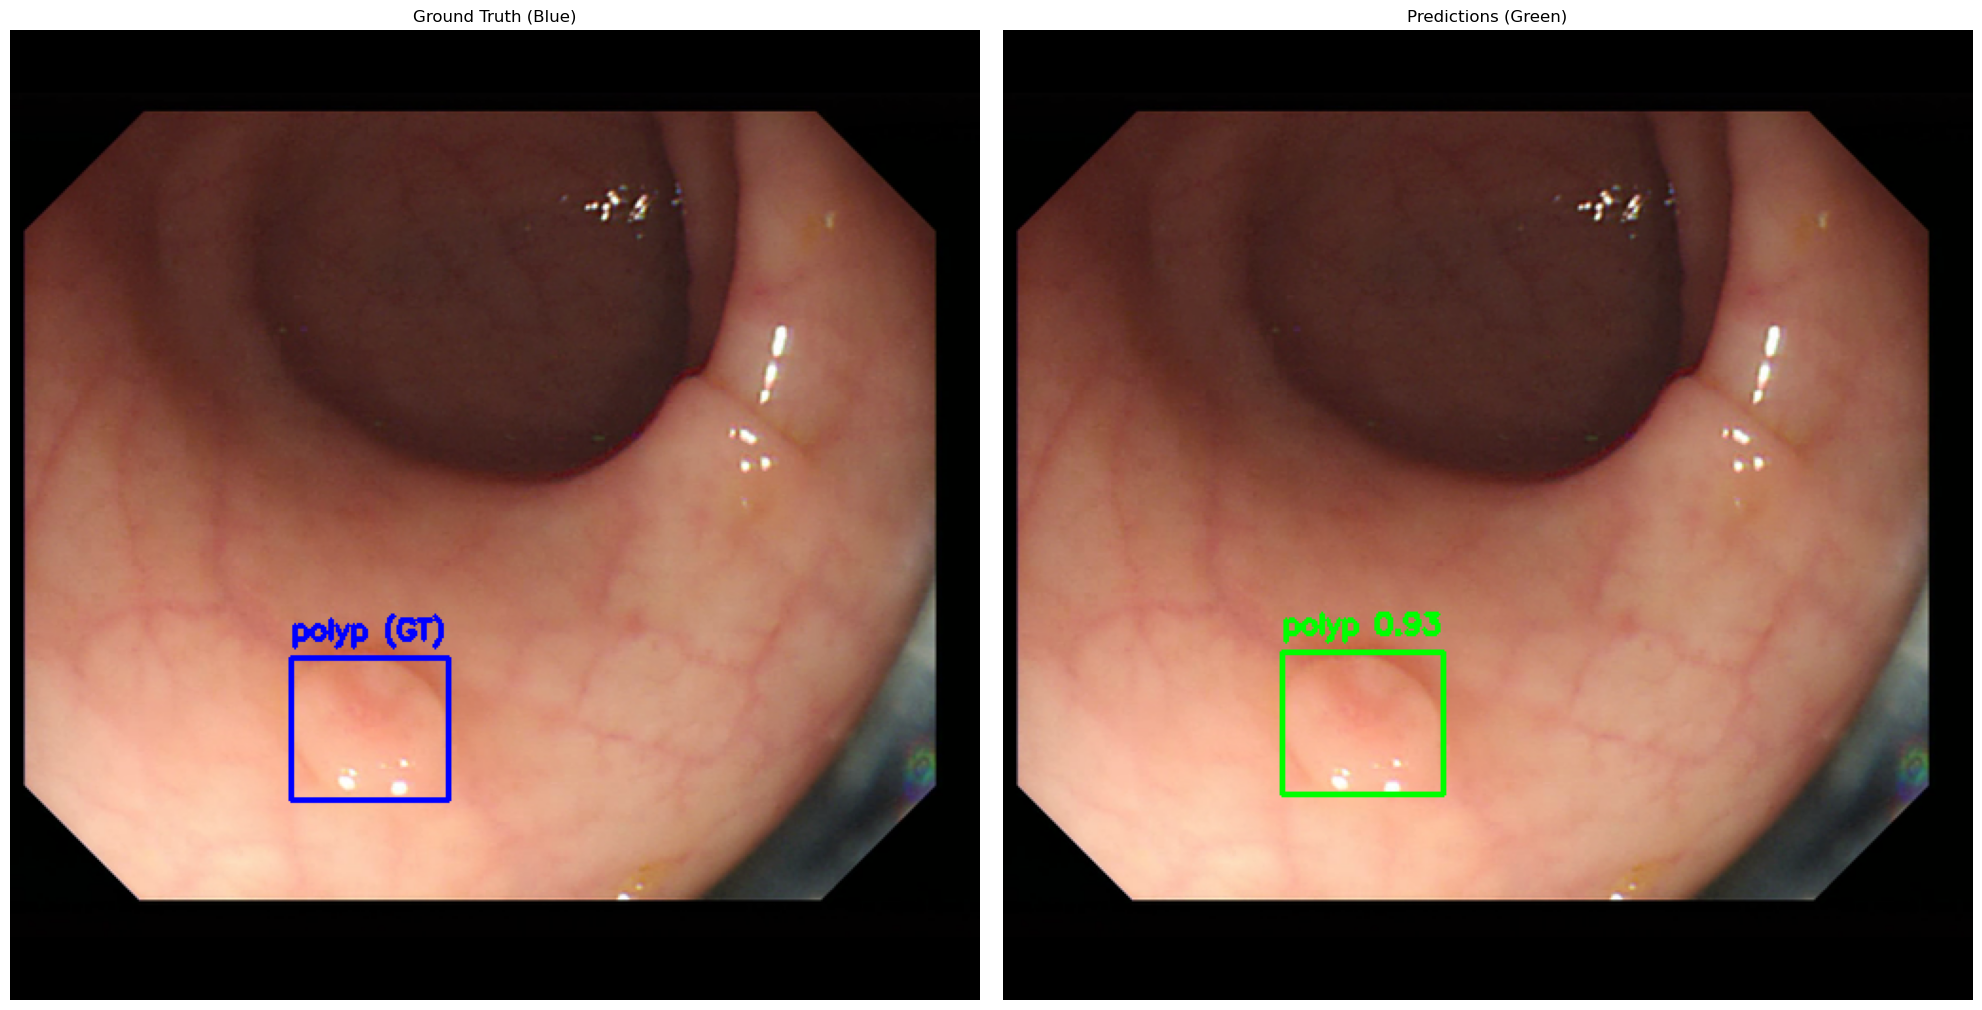


Image: CVC-ColonDB_158.png
Ground Truth Objects: 1
Detected Objects: 1

Detection Metrics:
True Positives: 1
False Positives: 0
False Negatives: 0
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

image 1/1 C:\Users\User\OneDrive\ \Diploma project\data_for_modeling\test\images\CVC-ClinicDB_520.png: 640x640 1 polyp, 54.1ms
Speed: 6.4ms preprocess, 54.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


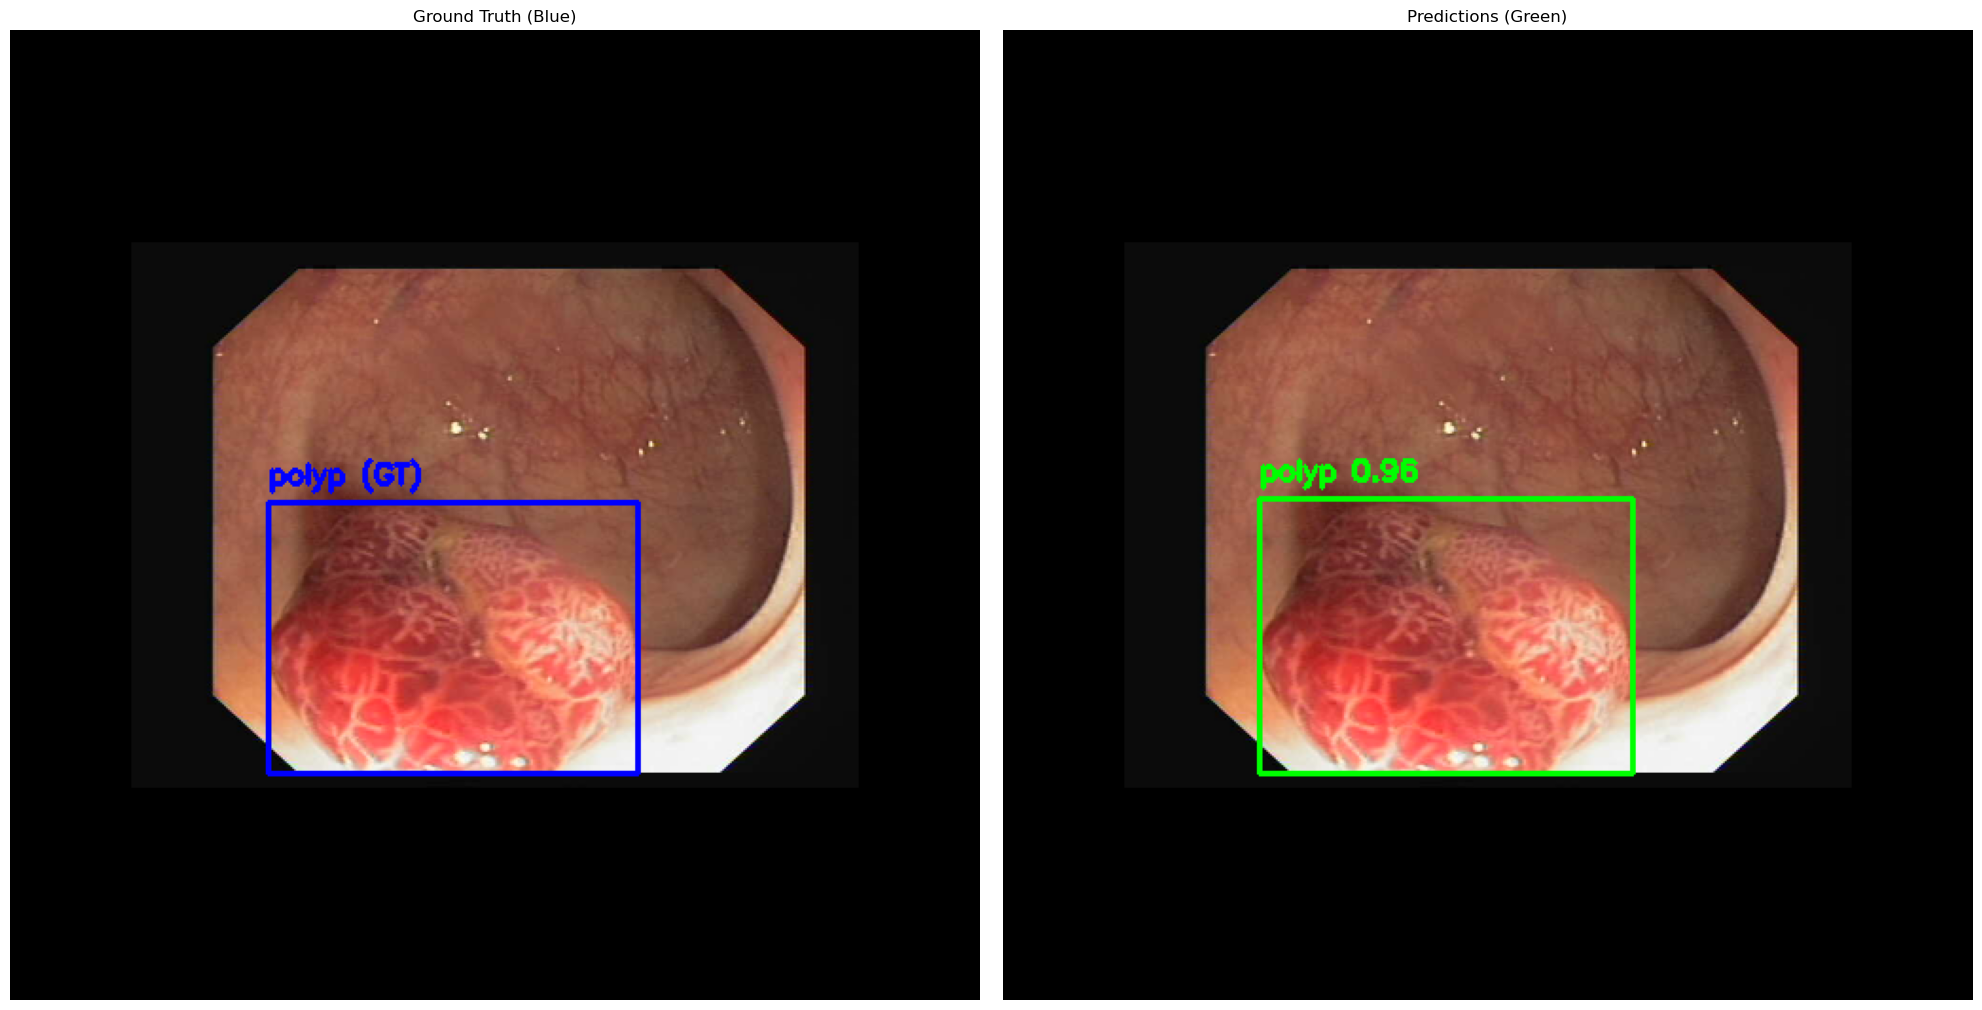


Image: CVC-ClinicDB_520.png
Ground Truth Objects: 1
Detected Objects: 1

Detection Metrics:
True Positives: 1
False Positives: 0
False Negatives: 0
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

image 1/1 C:\Users\User\OneDrive\ \Diploma project\data_for_modeling\test\images\Kvasir-SEG_cju6wn57mvooj0850rp78hhy7.png: 640x640 2 polyps, 54.2ms
Speed: 6.9ms preprocess, 54.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


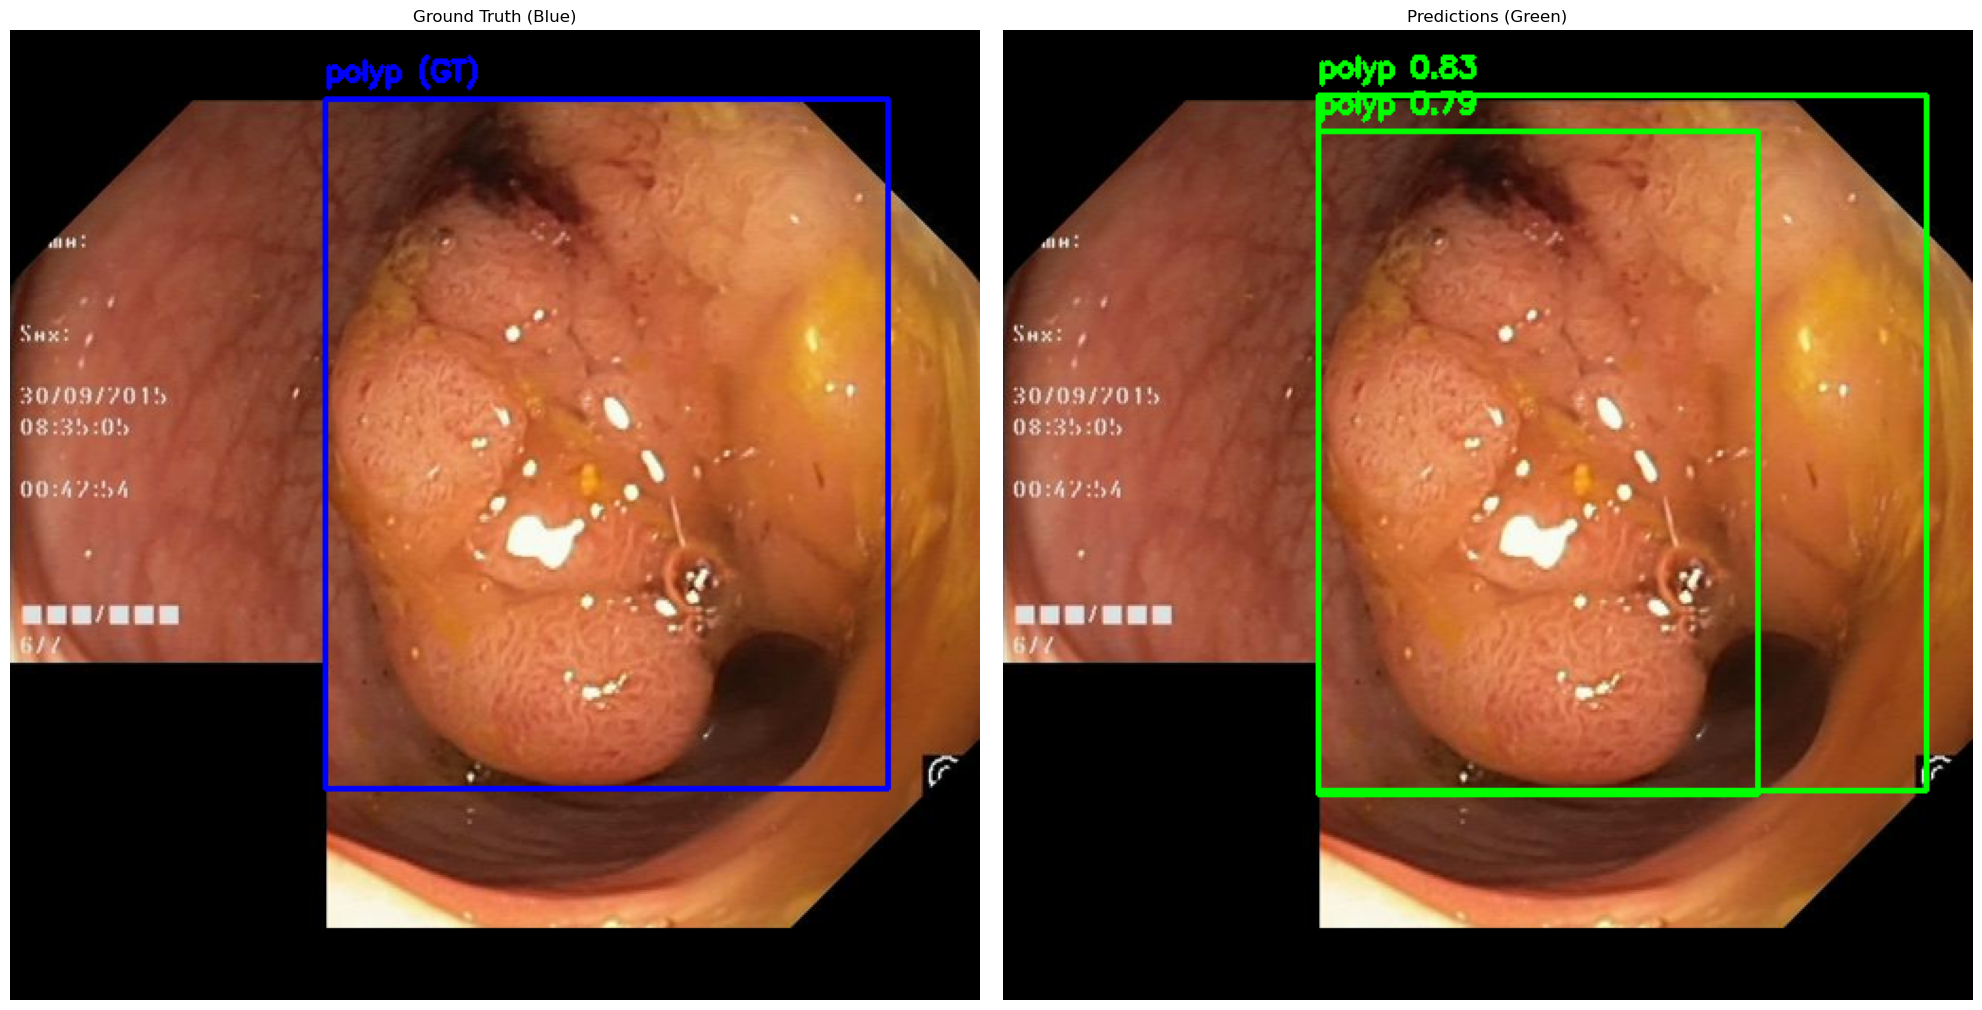


Image: Kvasir-SEG_cju6wn57mvooj0850rp78hhy7.png
Ground Truth Objects: 1
Detected Objects: 2

Detection Metrics:
True Positives: 1
False Positives: 1
False Negatives: 0
Precision: 0.50
Recall: 1.00
F1 Score: 0.67

image 1/1 C:\Users\User\OneDrive\ \Diploma project\data_for_modeling\test\images\data_6_ver2_333OLCV1_100H0016.png: 640x640 1 polyp, 58.3ms
Speed: 6.8ms preprocess, 58.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


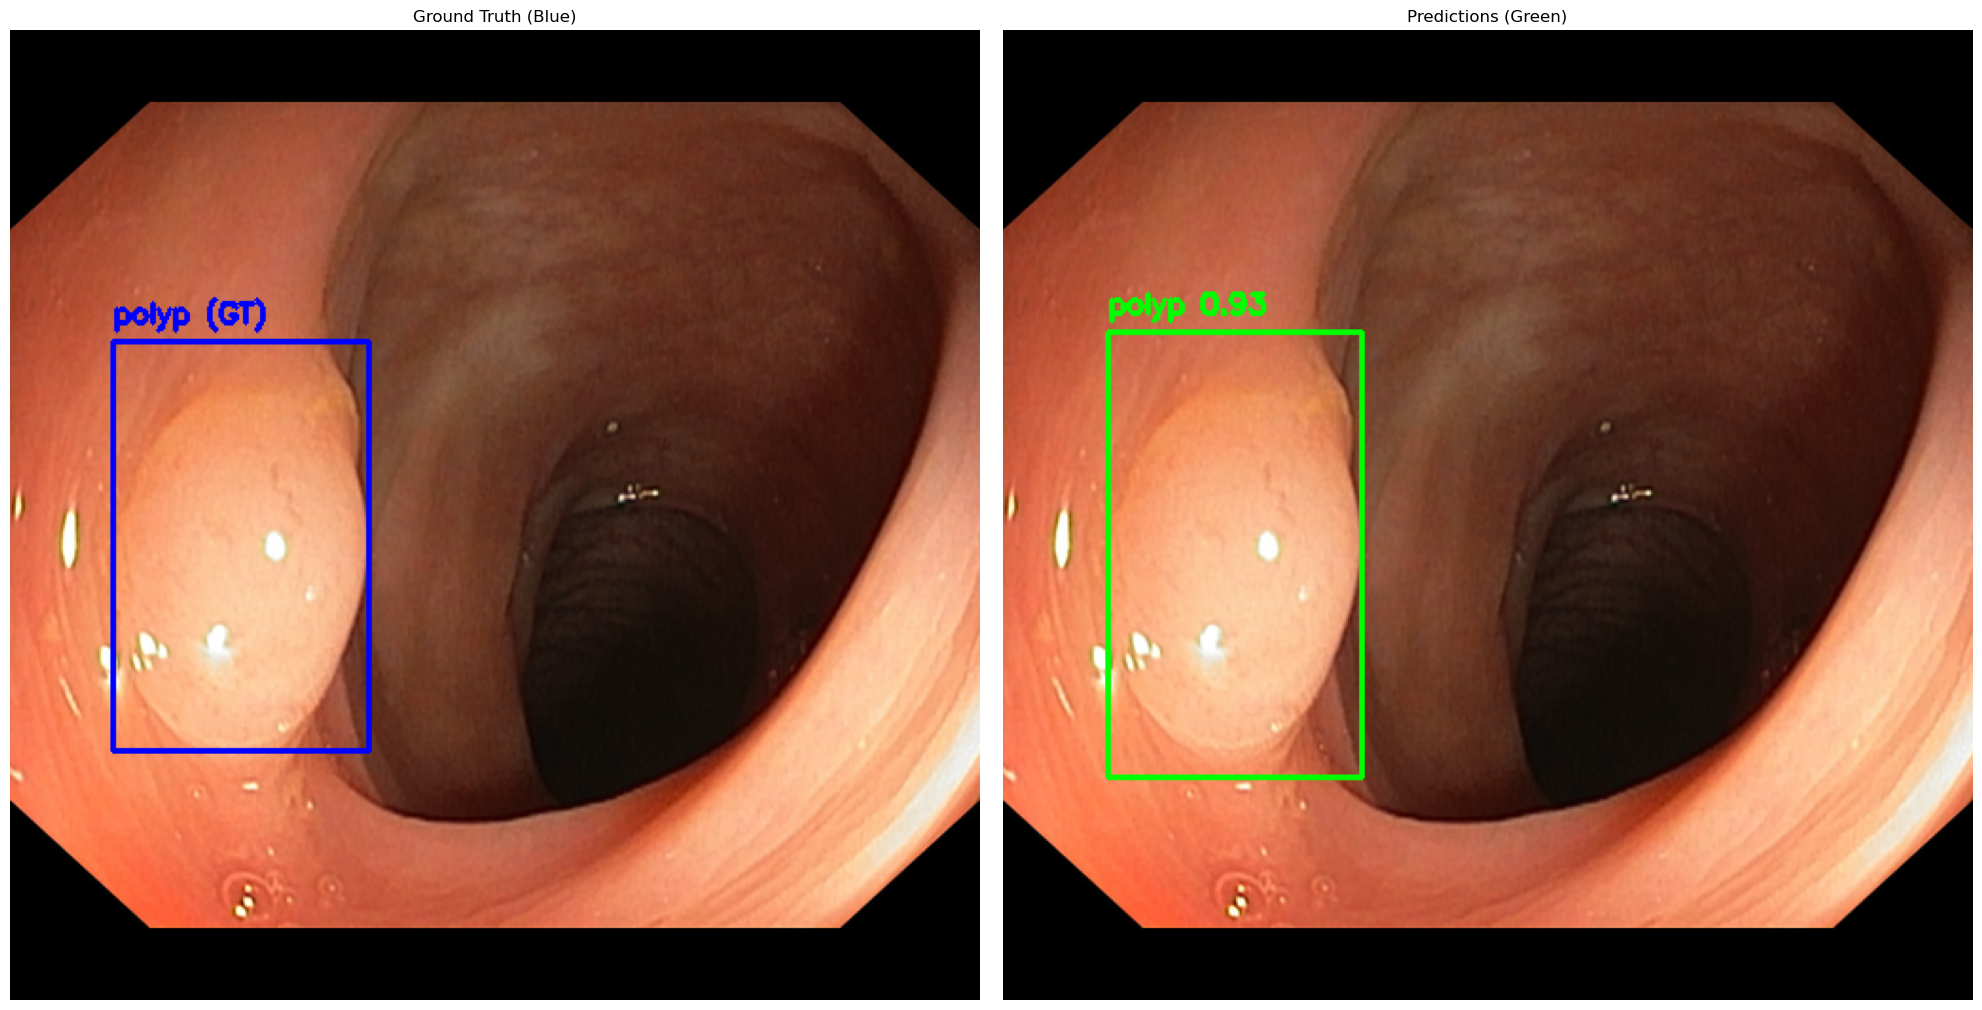


Image: data_6_ver2_333OLCV1_100H0016.png
Ground Truth Objects: 1
Detected Objects: 1

Detection Metrics:
True Positives: 1
False Positives: 0
False Negatives: 0
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

image 1/1 C:\Users\User\OneDrive\ \Diploma project\data_for_modeling\test\images\Kvasir-SEG_cju2oq5570avm079959o20op1.png: 640x640 1 polyp, 58.4ms
Speed: 10.5ms preprocess, 58.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


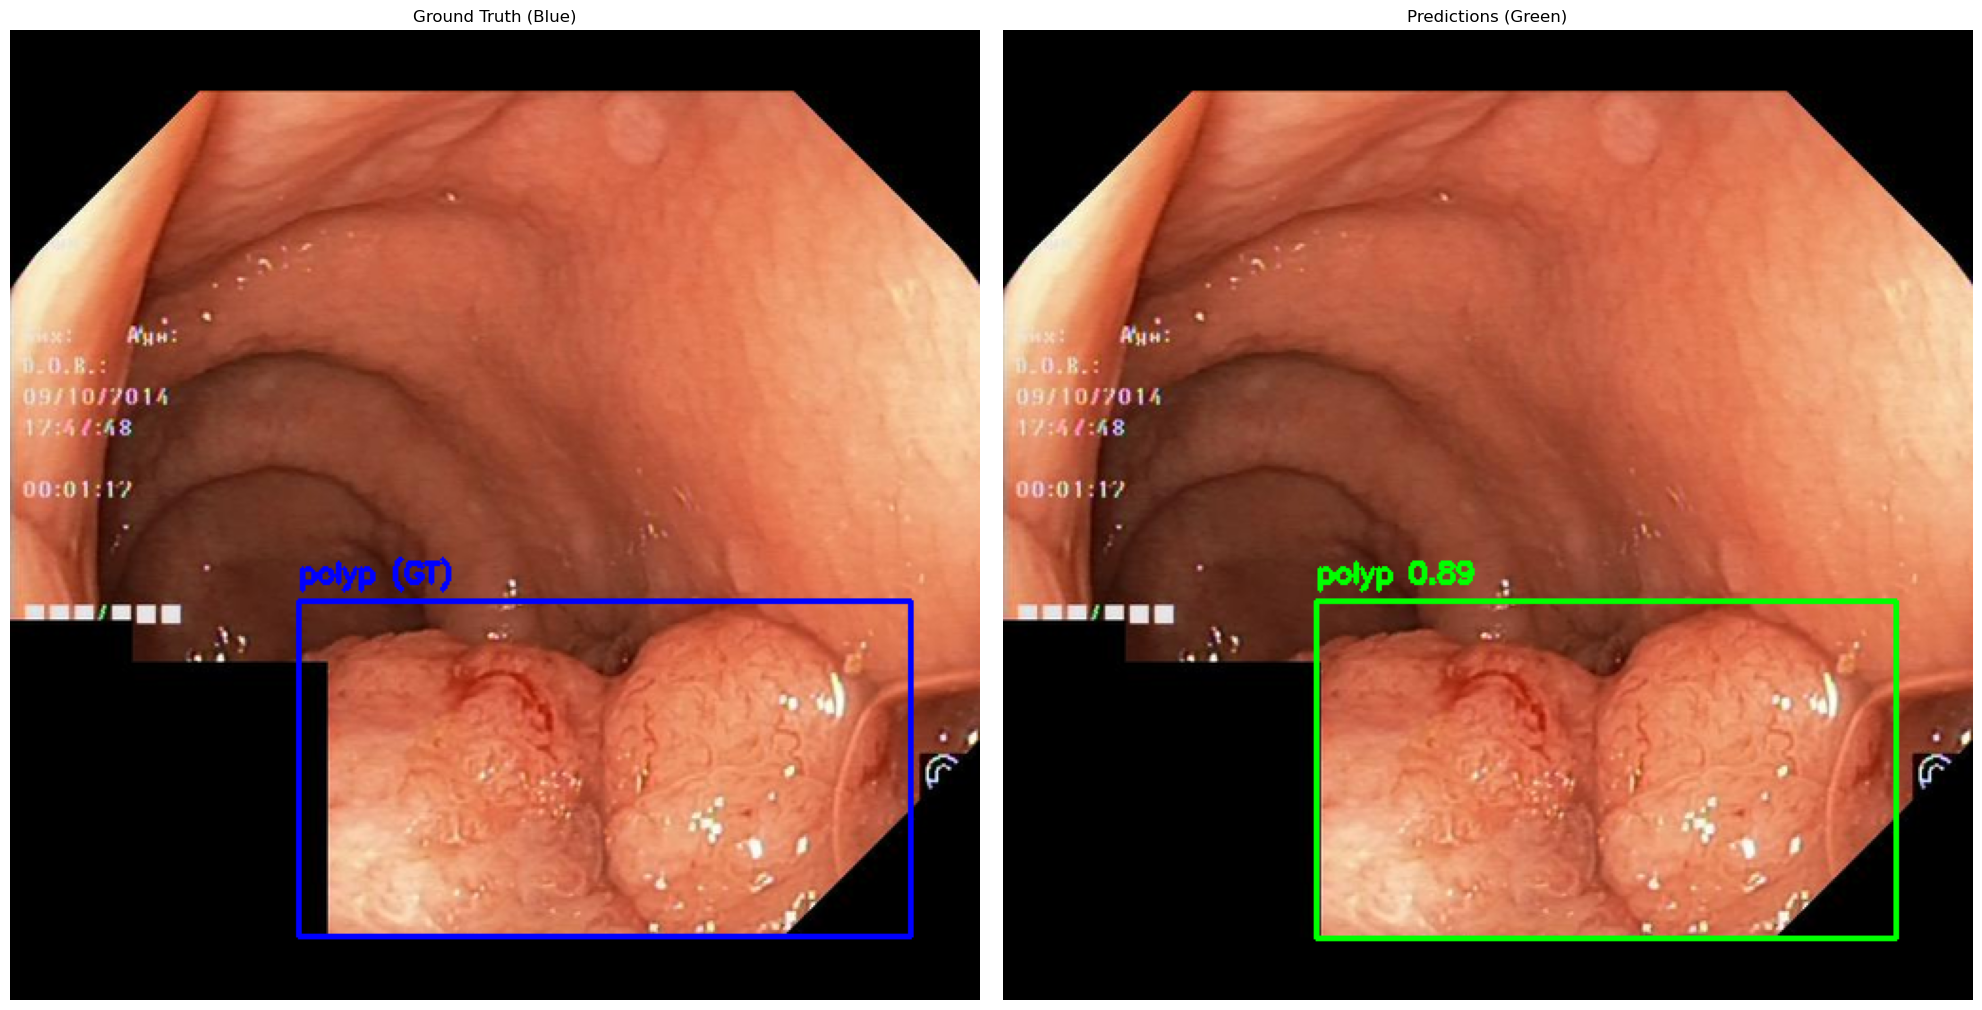


Image: Kvasir-SEG_cju2oq5570avm079959o20op1.png
Ground Truth Objects: 1
Detected Objects: 1

Detection Metrics:
True Positives: 1
False Positives: 0
False Negatives: 0
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

image 1/1 C:\Users\User\OneDrive\ \Diploma project\data_for_modeling\test\images\Kvasir-SEG_cju5jx7jzf7c90871c2i9aiov.png: 640x640 1 polyp, 57.7ms
Speed: 6.7ms preprocess, 57.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


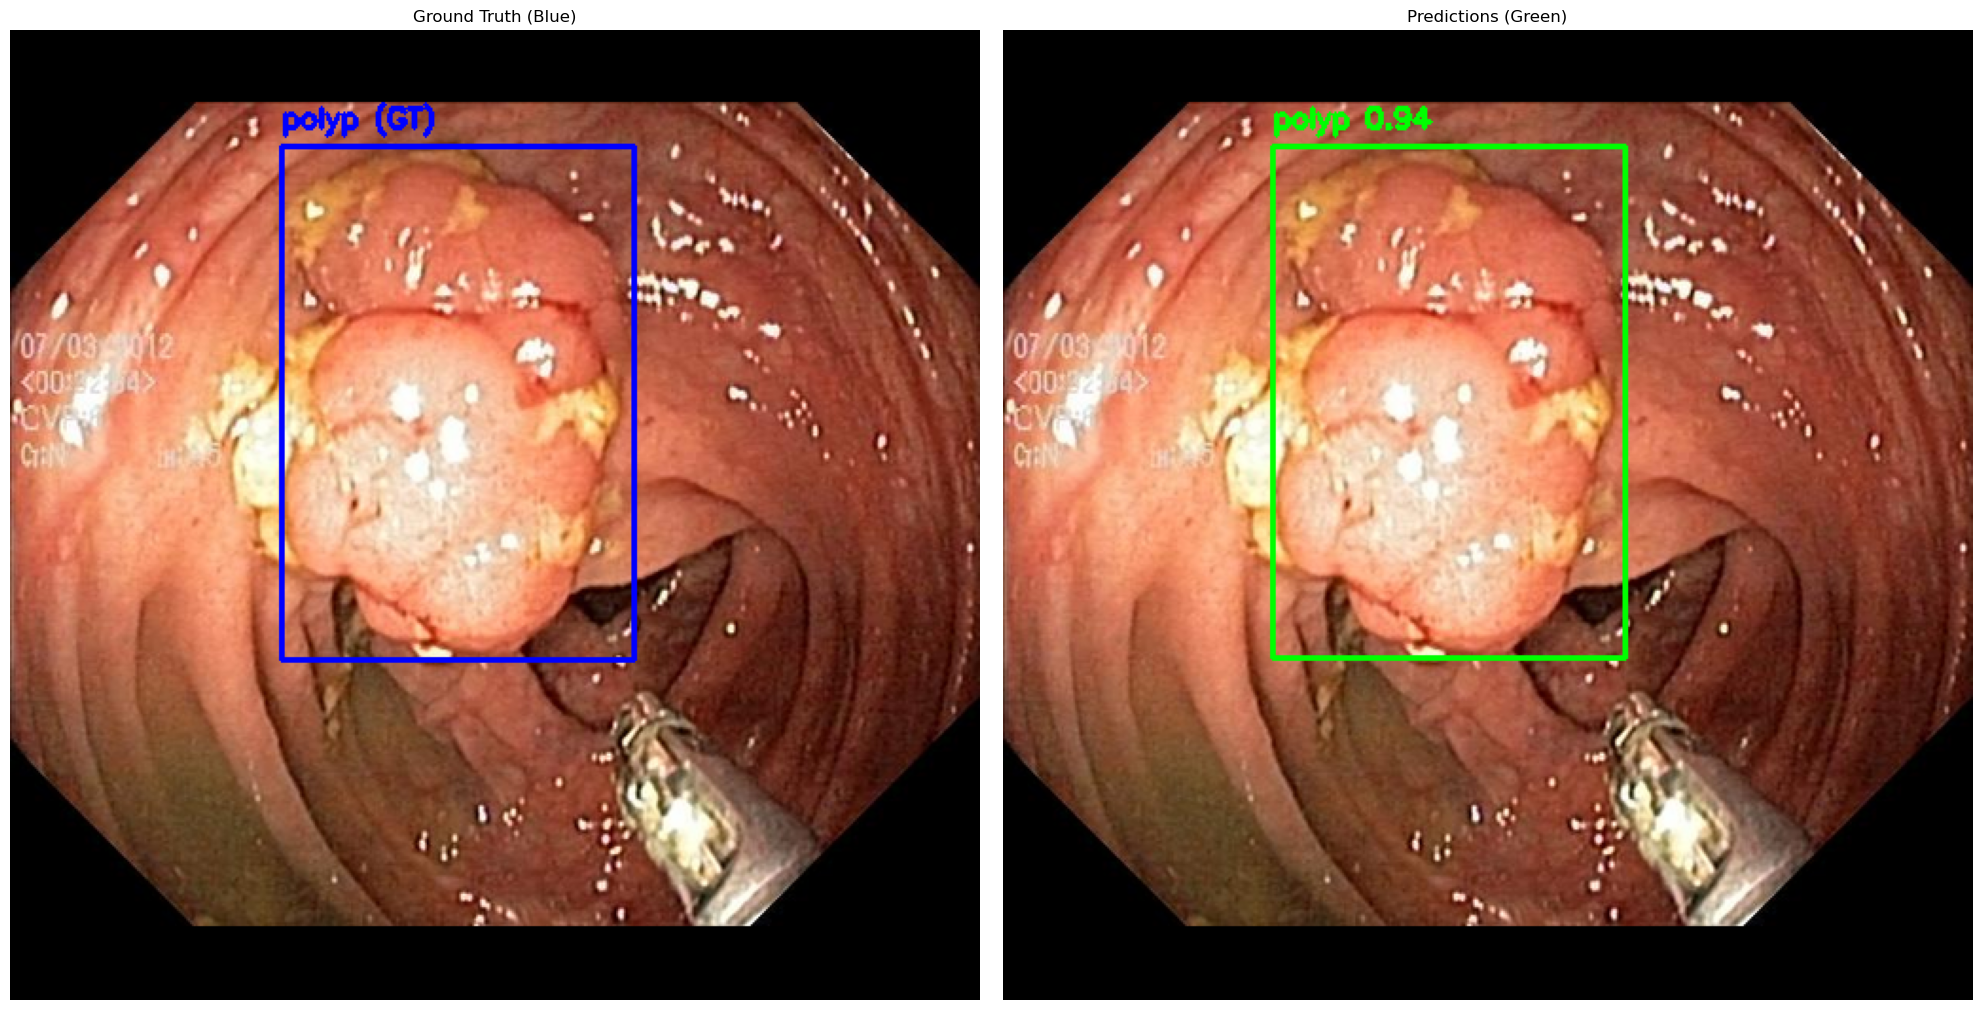


Image: Kvasir-SEG_cju5jx7jzf7c90871c2i9aiov.png
Ground Truth Objects: 1
Detected Objects: 1

Detection Metrics:
True Positives: 1
False Positives: 0
False Negatives: 0
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

image 1/1 C:\Users\User\OneDrive\ \Diploma project\data_for_modeling\test\images\CVC-ColonDB_185.png: 640x640 1 polyp, 58.4ms
Speed: 6.5ms preprocess, 58.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


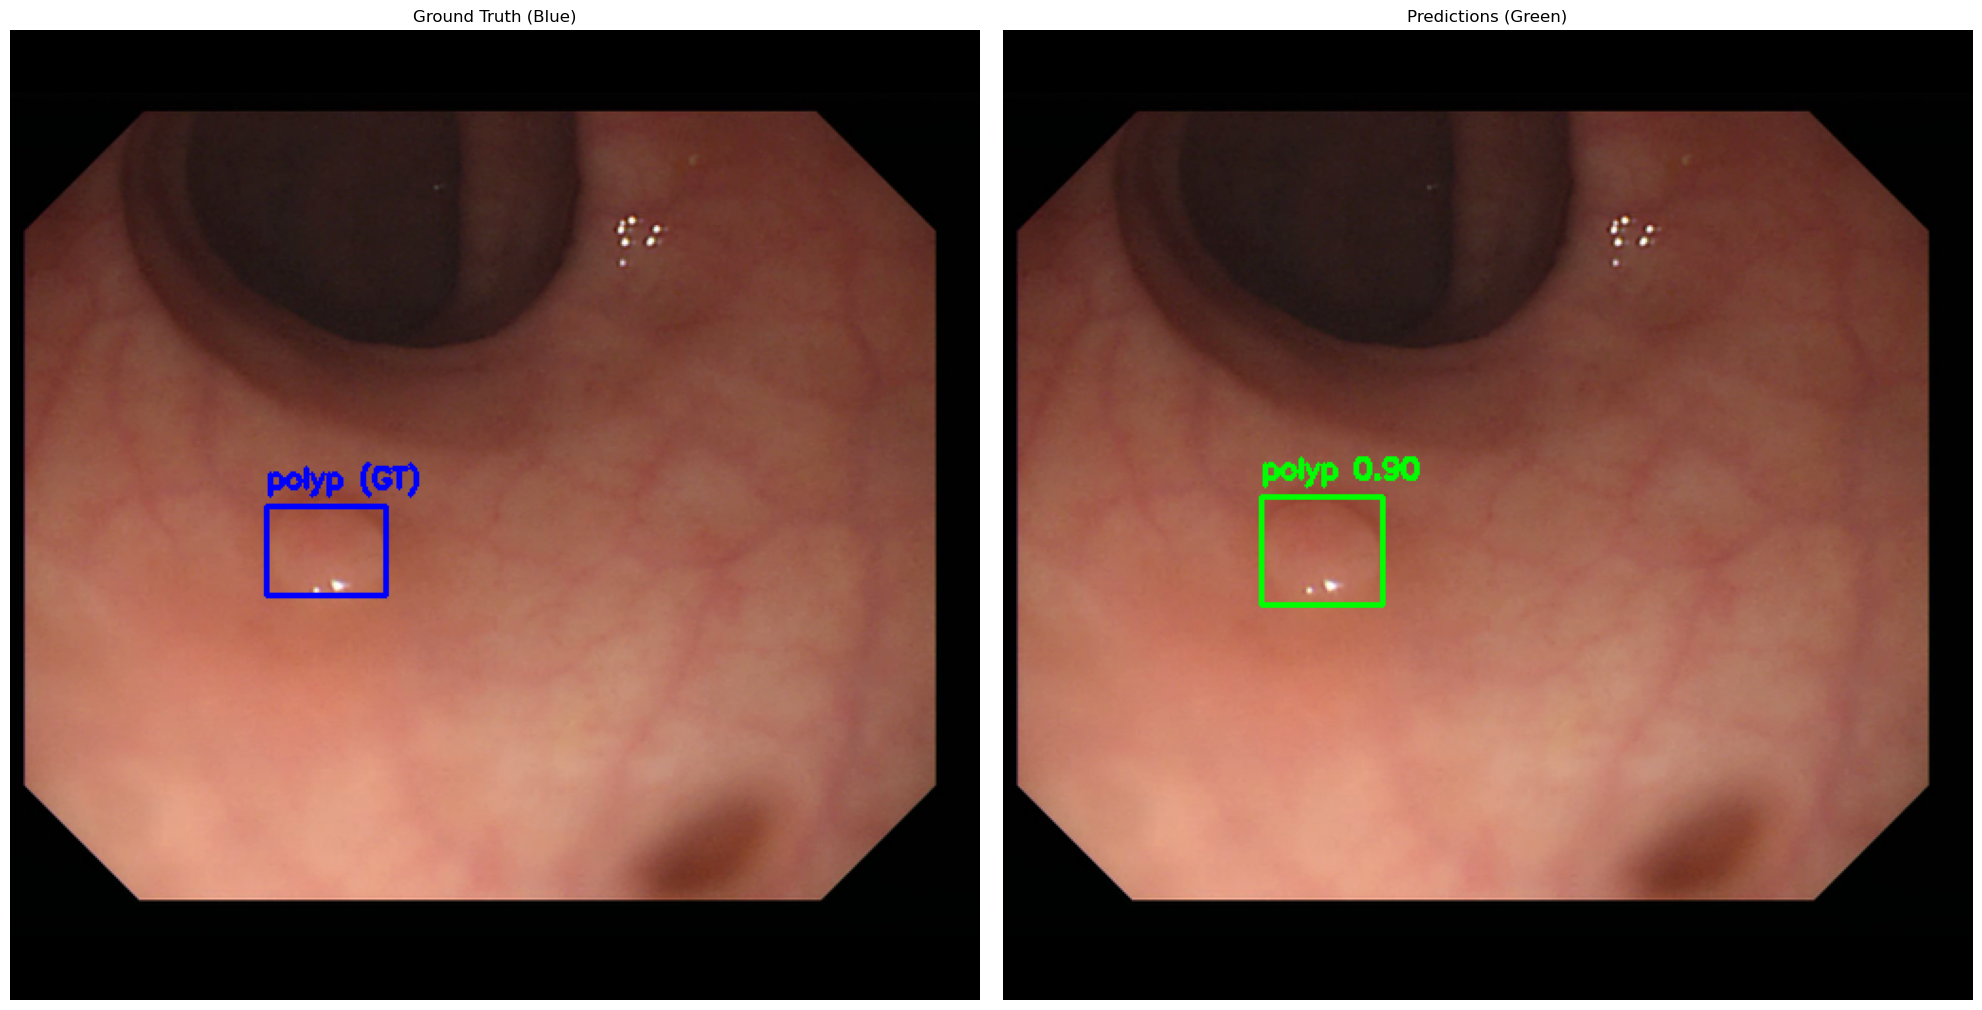


Image: CVC-ColonDB_185.png
Ground Truth Objects: 1
Detected Objects: 1

Detection Metrics:
True Positives: 1
False Positives: 0
False Negatives: 0
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

image 1/1 C:\Users\User\OneDrive\ \Diploma project\data_for_modeling\test\images\data_6_ver2_C3_EndoCV2021_00200.png: 640x640 1 polyp, 57.7ms
Speed: 6.3ms preprocess, 57.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


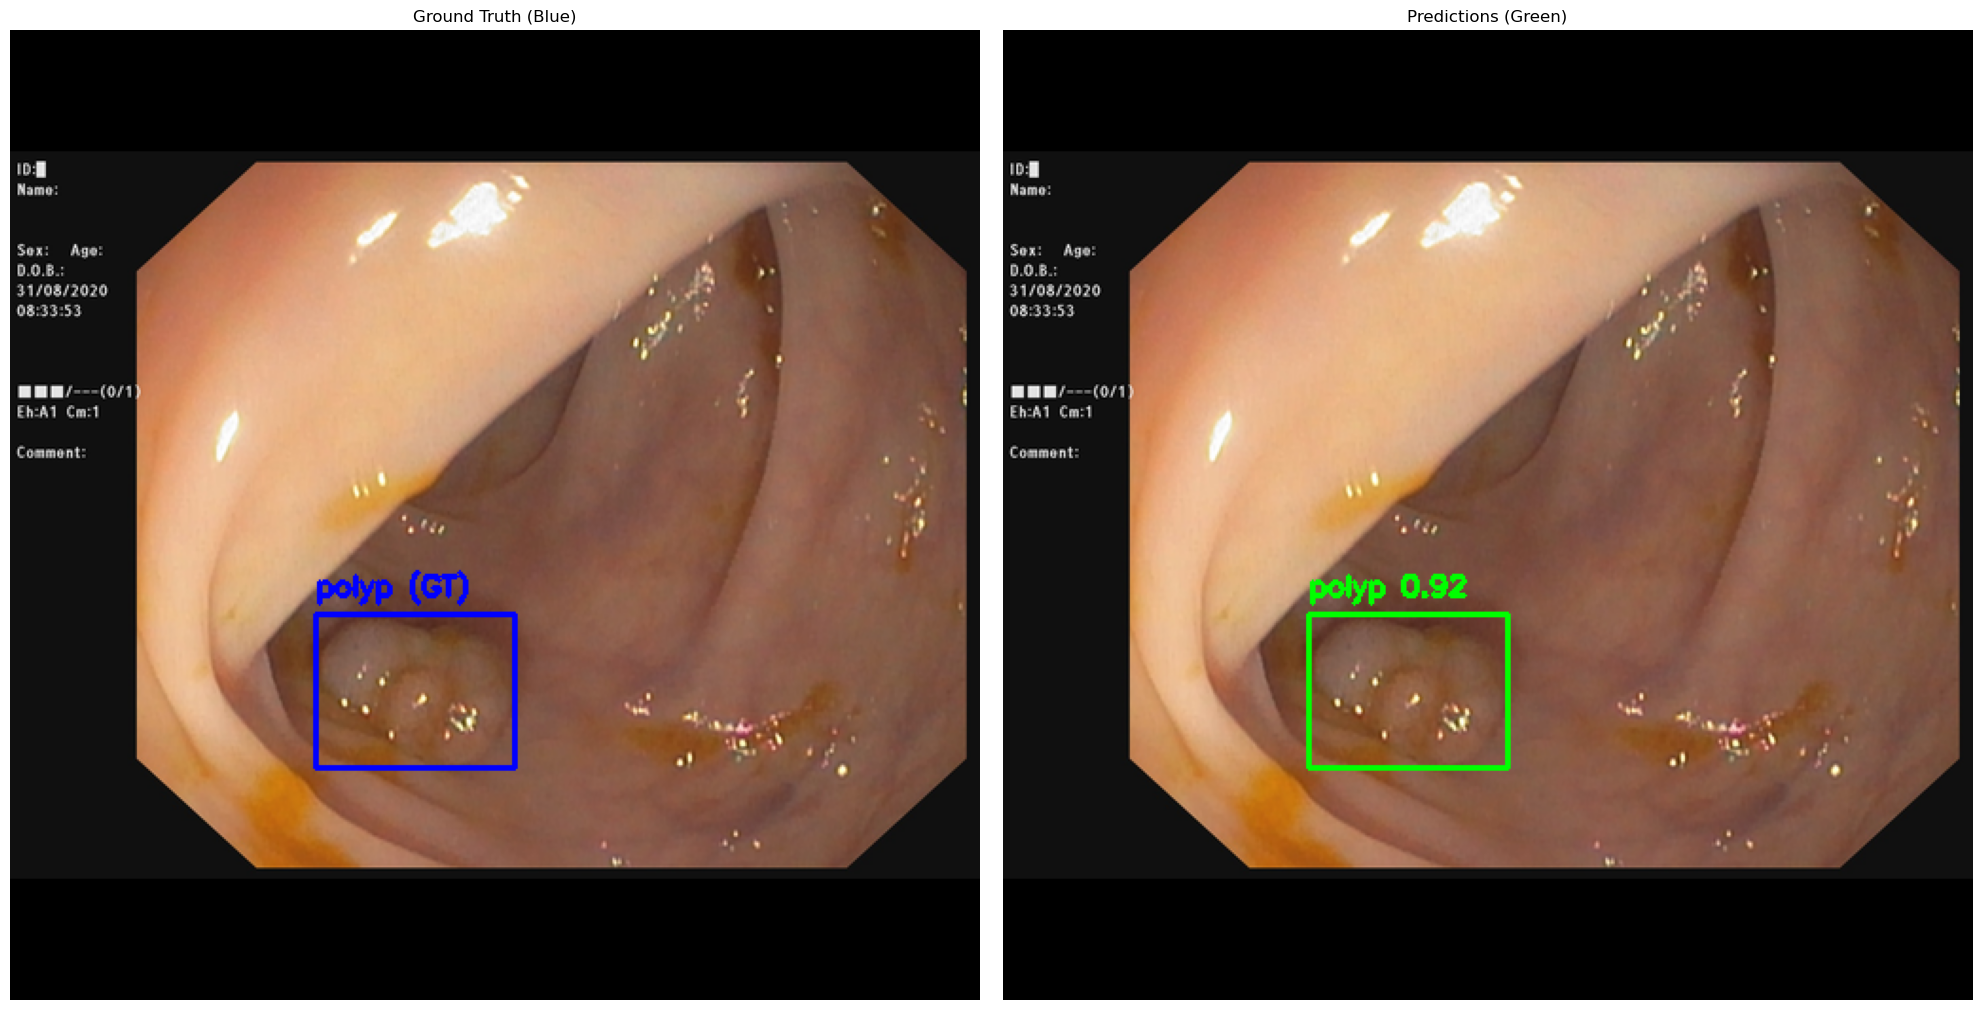


Image: data_6_ver2_C3_EndoCV2021_00200.png
Ground Truth Objects: 1
Detected Objects: 1

Detection Metrics:
True Positives: 1
False Positives: 0
False Negatives: 0
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

image 1/1 C:\Users\User\OneDrive\ \Diploma project\data_for_modeling\test\images\CVC-ClinicDB_532.png: 640x640 1 polyp, 57.6ms
Speed: 6.3ms preprocess, 57.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


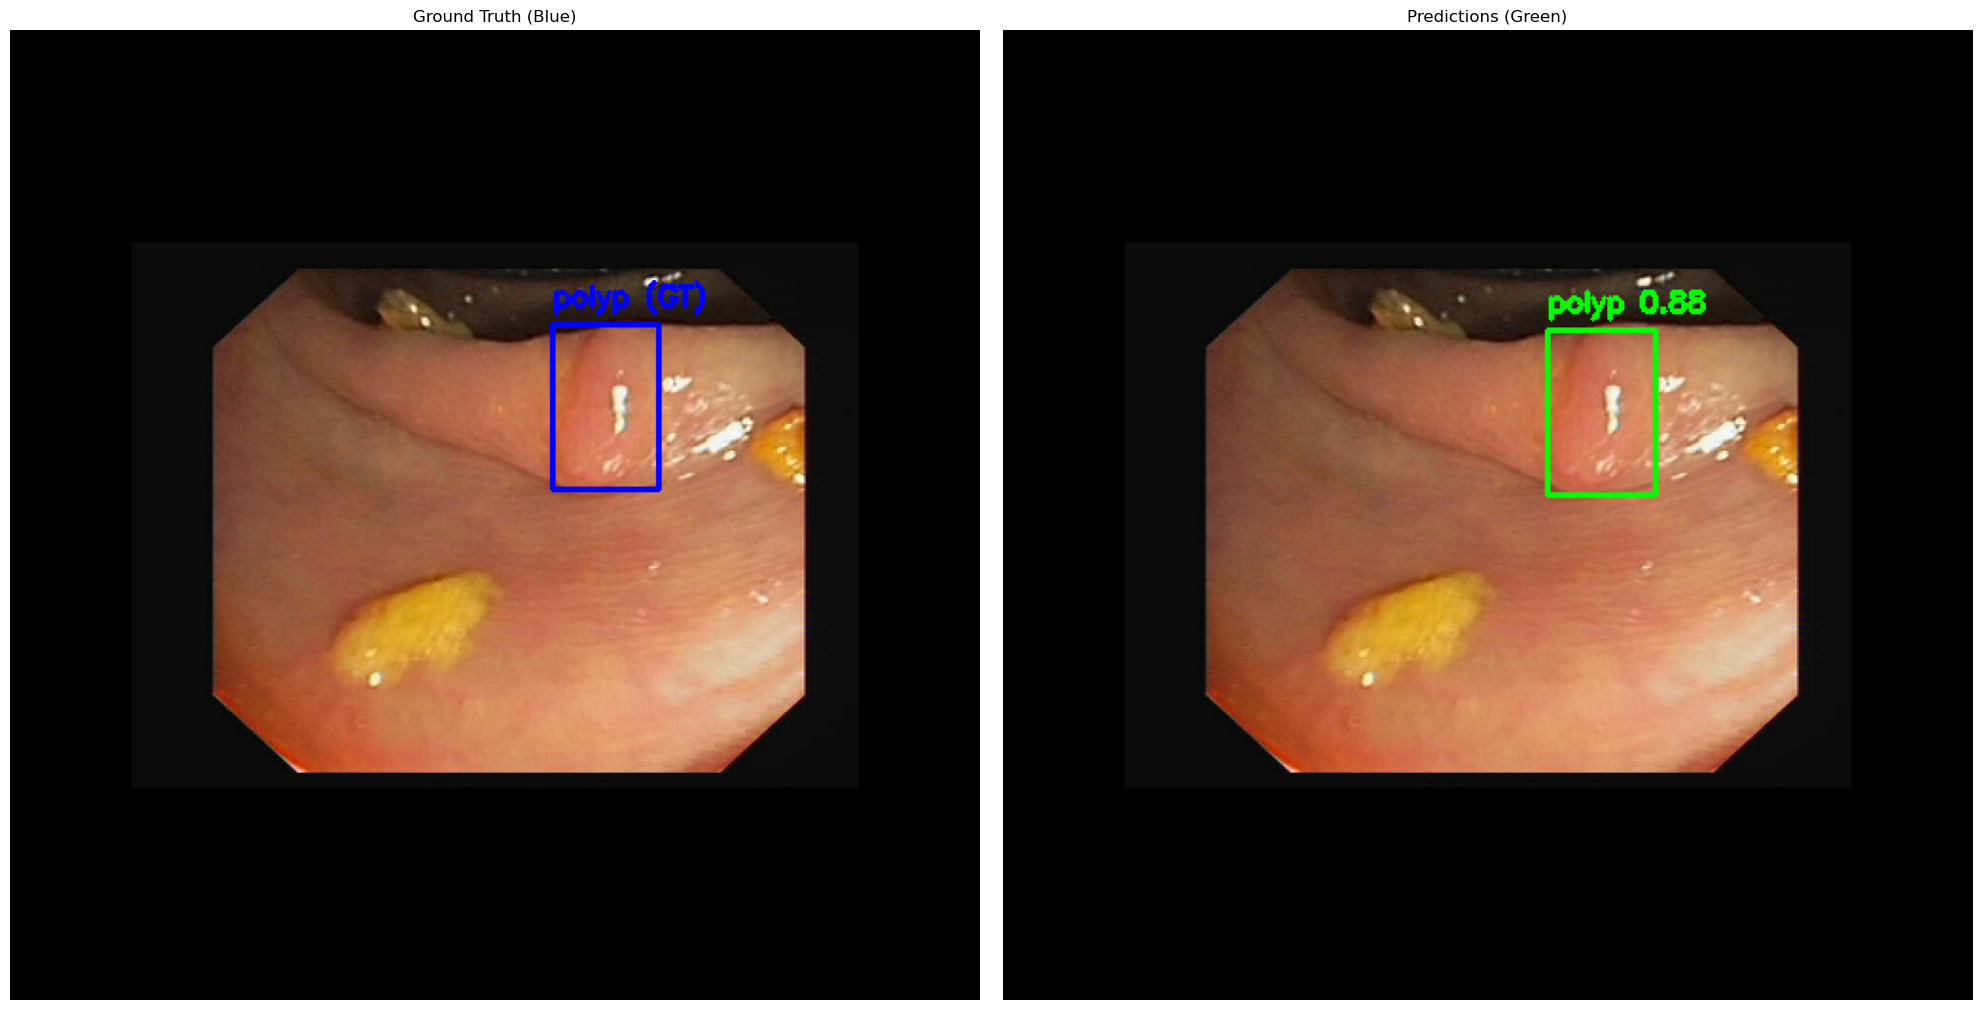


Image: CVC-ClinicDB_532.png
Ground Truth Objects: 1
Detected Objects: 1

Detection Metrics:
True Positives: 1
False Positives: 0
False Negatives: 0
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

image 1/1 C:\Users\User\OneDrive\ \Diploma project\data_for_modeling\test\images\CVC-ClinicDB_430.png: 640x640 1 polyp, 58.0ms
Speed: 12.2ms preprocess, 58.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


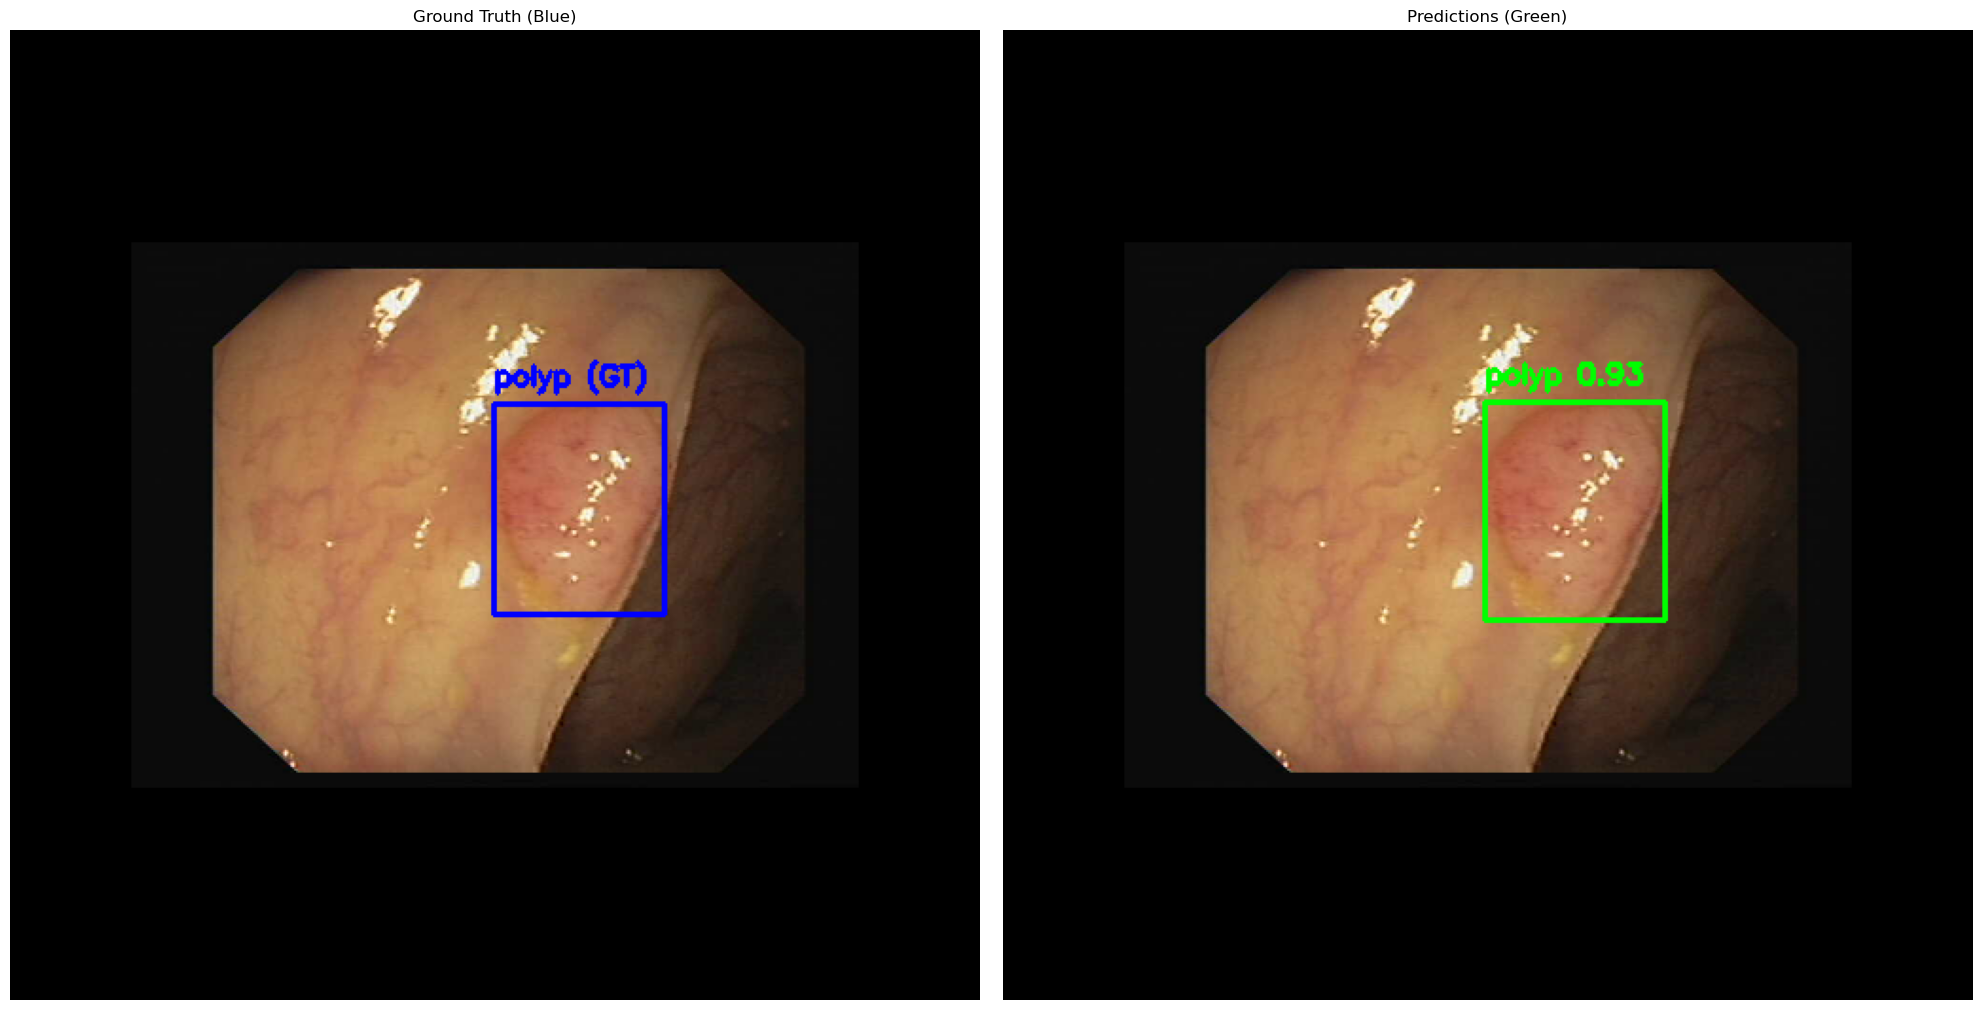


Image: CVC-ClinicDB_430.png
Ground Truth Objects: 1
Detected Objects: 1

Detection Metrics:
True Positives: 1
False Positives: 0
False Negatives: 0
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


In [104]:
def evaluate_predictions(pred_boxes, true_boxes, iou_threshold=0.5):
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    
    matched_true = set()
    
    for pred in pred_boxes:
        best_iou = 0
        best_match = None
        
        for i, true in enumerate(true_boxes):
            if i in matched_true:
                continue
                
            iou = calculate_iou(pred['bbox'], true['bbox'])
            if iou > best_iou and pred['class_id'] == true['class_id']:
                best_iou = iou
                best_match = i
        
        if best_iou >= iou_threshold:
            true_positives += 1
            matched_true.add(best_match)
        else:
            false_positives += 1
    
    false_negatives = len(true_boxes) - len(matched_true)
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }


test_pairs = find_test_images_and_labels()

if not test_pairs:
    MANUAL_TEST_PATH = r"C:\Users\User\OneDrive\Рабочий стол\Diploma project\data_for_modeling\test\images"
    MANUAL_LABEL_PATH = r"C:\Users\User\OneDrive\Рабочий стол\Diploma project\data_for_modeling\test\labels"
    
    if os.path.exists(MANUAL_TEST_PATH) and os.path.exists(MANUAL_LABEL_PATH):
        test_pairs = []
        for fmt in IMG_FORMATS:
            for img_path in glob.glob(os.path.join(MANUAL_TEST_PATH, fmt)):
                base_name = os.path.splitext(os.path.basename(img_path))[0]
                label_path = os.path.join(MANUAL_LABEL_PATH, f"{base_name}.txt")
                if os.path.exists(label_path):
                    test_pairs.append((img_path, label_path))

if not test_pairs:
    raise FileNotFoundError("No test images with labels found. Please check your paths")


selected_pairs = random.sample(test_pairs, min(NUM_IMAGES_TO_SHOW, len(test_pairs)))

print(f"\nComparing predictions with ground truth for {len(selected_pairs)} images:")
for img_path, label_path in selected_pairs:
  
    img = cv2.imread(img_path)
    img_height, img_width = img.shape[:2]
    
    results = model.predict(img_path, conf=CONF_THRESHOLD)[0]
    pred_boxes = []
    for box in results.boxes:
        pred_boxes.append({
            'class_id': int(box.cls),
            'bbox': box.xyxy[0].tolist(),
            'confidence': box.conf.item()
        })
    
    true_boxes = parse_yolo_label(label_path, img_width, img_height)
    
    metrics = evaluate_predictions(pred_boxes, true_boxes)
    
    plot_comparison(img, pred_boxes, true_boxes, model)
    
    print(f"\n{'='*80}")
    print(f"Image: {os.path.basename(img_path)}")
    print(f"Ground Truth Objects: {len(true_boxes)}")
    print(f"Detected Objects: {len(pred_boxes)}")
    print("\nDetection Metrics:")
    print(f"True Positives: {metrics['true_positives']}")
    print(f"False Positives: {metrics['false_positives']}")
    print(f"False Negatives: {metrics['false_negatives']}")
    print(f"Precision: {metrics['precision']:.2f}")
    print(f"Recall: {metrics['recall']:.2f}")
    print(f"F1 Score: {metrics['f1_score']:.2f}")